In [1]:
import pandas as pd

df = pd.read_csv('Steam_Reviews_1237320_20240621_sonic_frontiers.csv')
data = df[['ReviewText']]
data.dropna(inplace=True)
data_array = data.to_numpy()
data_string = []
for x in data_array:
  data_string.append(x[0].replace("Product received for free", "").replace("Product refunded", ""))

/tmp/ipykernel_4005/3068029177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


/home/fiqri/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fiqri/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


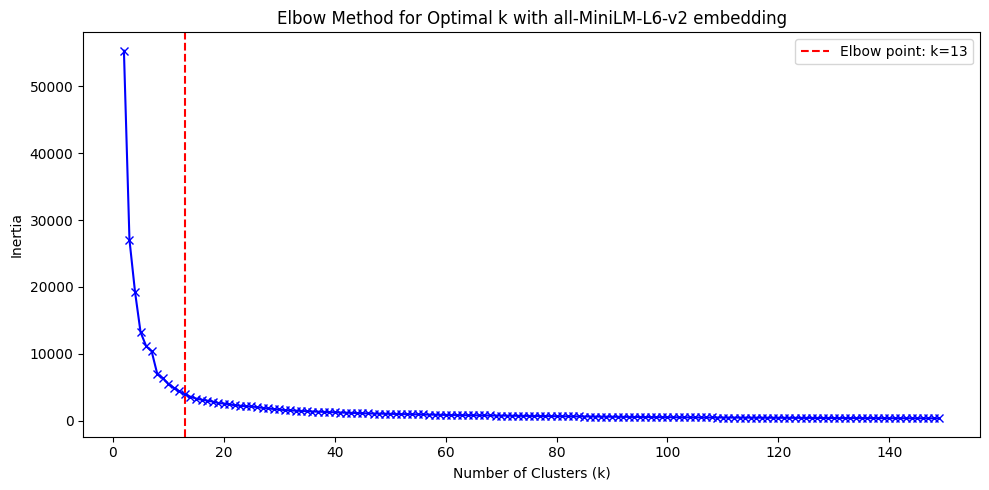

Optimal number of clusters for all-MiniLM-L6-v2 embedding: 13


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from umap import UMAP
from kneed import KneeLocator

def find_optimal_clusters(docs, 
                           embedding_model_name="all-MiniLM-L6-v2", 
                           umap_n_neighbors=35, 
                           umap_n_components=5, 
                           umap_min_dist=0.0, 
                           umap_metric='cosine',
                           max_k=150):
    # Handle embedding model
    if isinstance(embedding_model_name, str):
        embedding_model = SentenceTransformer(embedding_model_name)
    
    # Get embeddings
    embeddings = embedding_model.encode(docs)
    
    # Apply UMAP with fixed configuration
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors, 
        n_components=umap_n_components, 
        min_dist=umap_min_dist, 
        metric=umap_metric,
        random_state=42
    )
    reduced_embeddings = umap_model.fit_transform(embeddings)
    
    # Calculate inertia for different K values
    k_values = range(2, min(max_k, len(docs)))
    inertia_scores = []
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(reduced_embeddings)
        inertia_scores.append(kmeans.inertia_)
    
    # Find elbow point
    kn = KneeLocator(
        list(k_values), 
        inertia_scores, 
        curve='convex', 
        direction='decreasing'
    )
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, inertia_scores, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for Optimal k with {embedding_model_name} embedding')
    
    if kn.knee:
        plt.axvline(x=kn.knee, color='r', linestyle='--', 
                    label=f'Elbow point: k={kn.knee}')
        plt.legend()
    
    plt.savefig(f'{embedding_model_name} optimal elbow plot.png')
    plt.tight_layout()
    plt.show()
    
    return kn.knee if kn.knee else len(docs) // 10

docs = data_string
optimal_k = find_optimal_clusters(docs, "all-MiniLM-L6-v2")
print(f"Optimal number of clusters for all-MiniLM-L6-v2 embedding: {optimal_k}")

/home/fiqri/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


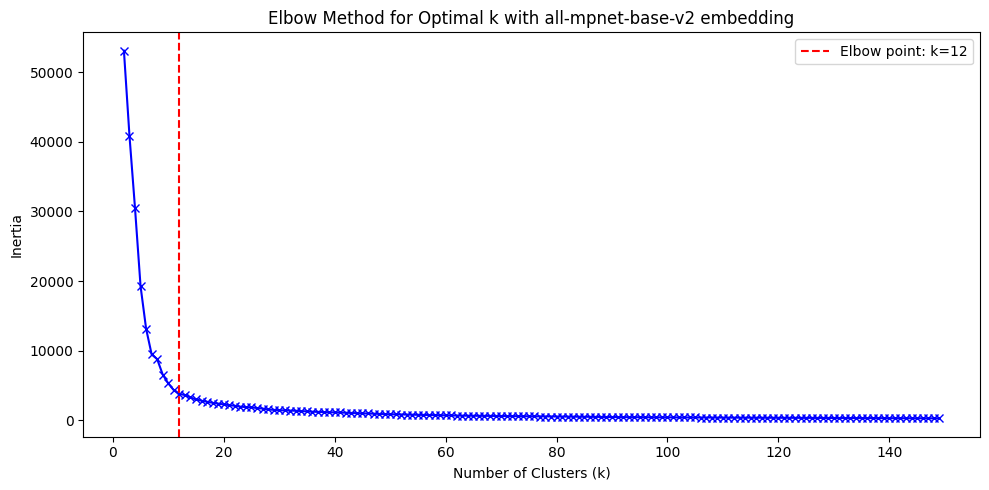

Optimal number of clusters with all-mpnet-base-v2 embedding: 12


In [3]:
optimal_k_all_mpnet_base_v2 = find_optimal_clusters(docs, "all-mpnet-base-v2")
print(f"Optimal number of clusters with all-mpnet-base-v2 embedding: {optimal_k_all_mpnet_base_v2}")